# Single vs. Multi-Agent Systems for Utilization Review

![](https://i.imgur.com/44rj36e.png)

### What is a utilization review?

A utilization review is a process in which a patient's care plan undergoes evaluation, typically for inpatient services on a case-by-case basis.

The **review determines the medical necessity of procedures and might make recommendations for alternative care or treatment**. Hospitals usually employ a utilization review (UR) healthcare professional who communicates with the insurance company to evaluate the criteria needed to approve surgeries or treatments.

## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain==0.3.27 langchain-community==0.3.27 langchain-openai==0.3.30 langgraph==0.6.5 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 5.5 MB/s eta 0:00:00


## Configure API Keys & Environment

Set your OpenAI API key for `ChatOpenAI` and set it in the environment

In [ ]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")


Enter your OpenAI API key (https://platform.openai.com/account/api-keys):
··········


## Imports

In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Markdown

## Sample Data (Guidelines, Care Plans, Patient Records)

This notebook uses **in-memory** Python lists to keep the demo self-contained.  
You can later swap these out for a database or API without changing the agent’s logic.

### What’s included
- **`medical_guidelines`** — evidence-style rules the agent can match against.
  - Fields: `procedure`, `diagnosis`, `required_symptoms` (list), `notes` (free text).
  - Example:
    ```python
    {
      "procedure": "CT Abdomen",
      "diagnosis": "Suspected Appendicitis",
      "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
      "notes": "CT imaging justified if appendicitis is unclear."
    }
    ```
- **`care_recommendations`** — next-step suggestions keyed by diagnosis.
  - Fields: `diagnosis`, `next_step`.
  - Example:
    ```python
    {
      "diagnosis": "Community-Acquired Pneumonia",
      "next_step": "Start empirical antibiotics; reserve CT for poor responders."
    }
    ```
- **`patient_records`** — patient data including what **procedure** has been recommended to them based on their **diagnosis**.
  - Fields: `patient_id`, `age`, `sex`, `symptoms` (list), `diagnosis`, `procedure`, `notes`.
  - Example:
    ```python
    {
      "patient_id": "P101",
      "age": 38,
      "sex": "Male",
      "symptoms": ["abdominal pain", "nausea"],
      "diagnosis": "Possible early appendicitis",
      "procedure": "CT Abdomen",
      "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."
    }
    ```

### How the agent uses these
- **Guideline matching**: `procedure` + `diagnosis` → pick the closest entry in `medical_guidelines`.
- **Validity check**: compare `patient_records[*].symptoms` vs. `required_symptoms` and read `notes`.
- **Care plan**: map `diagnosis` → `care_recommendations[*].next_step`.

In [ ]:
medical_guidelines = [
    {"procedure": "MRI Brain", "diagnosis": "Migraine", "required_symptoms": ["headache", "nausea"],
     "notes": "MRI not recommended unless neurological deficits or red flags present."},
    {"procedure": "CT Chest", "diagnosis": "Suspected Pulmonary Embolism", "required_symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "notes": "CTPA appropriate for high probability PE cases with positive D-dimer."},
    {"procedure": "MRI Lumbar Spine", "diagnosis": "Chronic Low Back Pain", "required_symptoms": ["back pain > 6 weeks", "neurological deficit"],
     "notes": "MRI only if pain persists despite conservative therapy and neuro signs are present."},
    {"procedure": "CT Chest", "diagnosis": "Community-Acquired Pneumonia", "required_symptoms": ["fever", "cough"],
     "notes": "CT Chest reserved for inconclusive X-rays or immunocompromised patients."},
    {"procedure": "CT Abdomen", "diagnosis": "Suspected Appendicitis", "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
     "notes": "CT imaging justified if appendicitis is unclear."}
]

care_recommendations = [
    {"diagnosis": "Migraine", "next_step": "Start migraine treatment; imaging not necessary unless red flags appear."},
    {"diagnosis": "Suspected Pulmonary Embolism", "next_step": "Begin anticoagulation and confirm with CTPA."},
    {"diagnosis": "Chronic Low Back Pain", "next_step": "Refer to physiotherapy; MRI only if neuro symptoms persist."},
    {"diagnosis": "Community-Acquired Pneumonia", "next_step": "Start empirical antibiotics; reserve CT for poor responders."},
    {"diagnosis": "Suspected Appendicitis", "next_step": "Do CT to confirm and refer for surgery if positive."}
]

patient_records = [
    {"patient_id": "P101", "age": 38, "sex": "Male", "symptoms": ["abdominal pain", "nausea"],
     "diagnosis": "Possible early appendicitis", "procedure": "CT Abdomen",
     "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."},
    {"patient_id": "P102", "age": 65, "sex": "Female", "symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "diagnosis": "Clinical suspicion of PE", "procedure": "CT Chest",
     "notes": "Wells score high probability; D-dimer positive."},
    {"patient_id": "P103", "age": 30, "sex": "Female", "symptoms": ["recurrent headache"],
     "diagnosis": "Classic migraine presentation", "procedure": "MRI Brain",
     "notes": "No neuro signs or red flags. Typical migraine pattern."}
]

### Tools for the Utilization Review Agent

These are **tools** (decorated with `@tool`) that the agent can call during a review.  
They encapsulate domain logic and return **small, structured dicts** the agent can reason over.

#### Summary of tools

| Tool | Purpose | Inputs | Output keys |
|---|---|---|---|
| `fetch_patient_record` | Retrieve and summarize a patient chart from in-memory data | `patient_id: str` | `patient_summary` _(str)_, or `error` |
| `match_guideline` | Pick the closest clinical guideline for a (procedure, diagnosis) pair using the LLM | `procedure: str`, `diagnosis: str` | `matched_guideline` _(str)_ |
| `check_guideline_validity` | Validate whether patient symptoms/notes meet the guideline’s criteria | `symptoms: list[str]`, `required_symptoms: list[str]`, `notes: str` | `validity_result` _(str)_ |
| `recommend_care_plan` | Suggest next steps for the given diagnosis | `diagnosis: str` | `recommendation` _(str)_ |

> All LLM-backed tools use `ChatOpenAI` (temperature = 0, streaming enabled in code) and return **concise textual justifications** under a single key.

#### Typical call order used by the agent
1. `fetch_patient_record(patient_id)` → summarize context  
2. `match_guideline(procedure, diagnosis)` → find best-fit rule  
3. `check_guideline_validity(symptoms, required_symptoms, notes)` → approve vs. needs review  
4. `recommend_care_plan(diagnosis)` → action steps / alternatives

#### Example outputs (shape)
```json
// fetch_patient_record
{ "patient_summary": "Patient ID: P102\nAge: 65, Sex: Female\nReported Symptoms: chest pain, shortness of breath, tachycardia\nPreliminary Diagnosis: Clinical suspicion of PE\nRequested Procedure: CT Chest\nClinical Notes: Wells score high probability; D-dimer positive." }

// match_guideline
{ "matched_guideline": "CTPA is appropriate for high-probability PE with positive D-dimer. Required symptoms: chest pain, shortness of breath, tachycardia. Caveats: ensure renal function adequate for contrast." }

// check_guideline_validity
{ "validity_result": "Criteria met: symptoms align and notes indicate high probability (Wells) with positive D-dimer. Imaging is medically necessary." }

// recommend_care_plan
{ "recommendation": "Begin anticoagulation and confirm with CTPA; monitor hemodynamics; consider risk stratification." }


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@tool
def fetch_patient_record(patient_id: str) -> dict:
    """
    Fetches and summarizes a patient record based on the given patient ID.

    Returns a human-readable summary including age, sex, symptoms, diagnosis, procedure, and clinical notes.
    Also includes the raw patient record in case other tools or agents need structured access.

    Args:
        patient_id (str): The unique identifier for the patient.

    Returns:
        dict: {
            "summary": str,  # Natural language summary of the patient record
        }
    """
    for record in patient_records:
        if record["patient_id"] == patient_id:
            summary = (
                f"Patient ID: {record['patient_id']}\n"
                f"Age: {record['age']}, Sex: {record['sex']}\n"
                f"Reported Symptoms: {', '.join(record['symptoms'])}\n"
                f"Preliminary Diagnosis: {record['diagnosis']}\n"
                f"Requested Procedure: {record['procedure']}\n"
                f"Clinical Notes: {record['notes']}"
            )
            return {
                "patient_summary": summary
            }
    return {"error": "Patient record not found."}


@tool
def match_guideline(procedure: str, diagnosis: str) -> dict:
    """
    Match a given procedure and diagnosis to the most relevant clinical guideline.

    Args:
        procedure (str): The medical procedure being requested.
        diagnosis (str): The diagnosis related to the procedure.

    Returns:
        dict: A summary of the best matching guideline if found, or a message indicating no match.
    """
    # here context could be from the vector database also if needed
    context = "\n".join([
        f"{i+1}. Procedure: {g['procedure']}, Diagnosis: {g['diagnosis']}, Required Symptoms: {g['required_symptoms']}, Notes: {g['notes']}"
        for i, g in enumerate(medical_guidelines)])

    prompt = f"""You are a clinical reviewer assessing whether a requested medical procedure aligns with existing evidence-based guidelines.

Instructions:
- Analyze the patient's procedure and diagnosis.
- Compare against the list of provided clinical guidelines.
- Select the guideline that best fits the case by reasoning on the common matches considering procedure and diagnosis.
- If none match, respond: "No appropriate guideline found for this case."
- If a match is found, summarize the matching guideline clearly including any required symptoms or caveats.

Patient Case:
- Procedure: {procedure}
- Diagnosis: {diagnosis}

Available Guidelines:
{context}
"""
    result = llm.invoke(prompt).content
    return {"matched_guideline": result}


@tool
def check_guideline_validity(symptoms: list, required_symptoms: list, notes: str) -> dict:
    """
    Determine whether the patient's symptoms and notes satisfy the guideline criteria for medical necessity.

    Args:
        symptoms (list): List of symptoms recorded in the patient’s record.
        required_symptoms (list): List of symptoms required by the matched guideline.
        notes (str): Free-text clinical notes associated with the patient case.

    Returns:
        dict: A string with justification explaining whether the procedure is valid or not.
    """
    prompt = f"""You are validating a medical procedure request based on documented symptoms and clinical context.

Instructions:
- Assess whether the patient's symptoms and notes fulfill the required guideline criteria.
- Consider nuances or indirect references (e.g. "long flight" implies immobility).
- Provide a reasoned judgment if the procedure is medically necessary.
- If it does not qualify, explain exactly which criteria are unmet.

Input:
- Patient Symptoms: {symptoms}
- Required Symptoms from Guideline: {required_symptoms}
- Clinical Notes: {notes}
"""
    result = llm.invoke(prompt).content
    return {"validity_result": result}


@tool
def recommend_care_plan(diagnosis: str) -> dict:
    """
    Recommend a follow-up care plan based on a given diagnosis.

    Args:
        diagnosis (str): The diagnosis to evaluate for next steps.

    Returns:
        dict: A recommendation string describing the suggested care plan or a fallback message if no match is found.
    """
    options = "\n".join([
        f"{i+1}. Diagnosis: {c['diagnosis']}, Recommendation: {c['next_step']}"
        for i, c in enumerate(care_recommendations)])

    prompt = f"""You are a clinical support assistant suggesting appropriate next steps for a given medical diagnosis.

Instructions:
- Analyze the given diagnosis.
- Choose the closest match from the list of known recommendations.
- Explain why the match is appropriate.
- If no suitable recommendation is found, return: "No care recommendation found for this diagnosis."

Diagnosis Provided:
{diagnosis}

Available Recommendations:
{options}
"""
    result = llm.invoke(prompt).content
    return {"recommendation": result}

## Single-Agent System

The diagram illustrates a **single-agent architecture** for healthcare decision support.  
Unlike the multi-agent setup, all responsibilities are managed by one agent that coordinates tool usage directly.

![](https://i.imgur.com/s9hSJ6l.png)

#### 1. Central Agent
- Operates with a **System Prompt** and an **LLM**.  
- Handles **intake, guideline validation, and care recommendations** in one unified flow.  
- Decides when and how to call tools to process patient data and reach decisions.

#### 2. Tools Layer
- The agent directly invokes tools for each task:  
  - 📄 **Fetch Patient Record** – retrieves patient history from the dataset  
  - 📊 **Match Guideline** – finds relevant medical guideline for diagnosis  
  - ✅ **Check Guideline Validity** – verifies if symptoms meet required criteria  
  - 💡 **Fetch Recommendation** – suggests treatments or interventions  

#### 3. Datasets Layer
- **Patient Records** – stores structured patient data  
- **Medical Guidelines** – reference standards for diagnosis and procedures  
- **Care Recommendations** – library of treatment or care pathways  

#### 4. Final Output
- The single agent consolidates results from all tools.  
- Produces a **Final Decision Output** including:  
  - Decision status  
  - Reasoning  
  - Recommended next steps  

In [ ]:
single_agent_prompt = """
You are a senior medical review assistant responsible for evaluating healthcare procedure requests.

You must call relevant tools to do the following:
1. Retrieve the full patient record using the patient ID.
2. Match the requested procedure and diagnosis to clinical guidelines.
3. Validate the match by comparing the patient's symptoms and notes to the guideline's requirements.
4. Recommend the appropriate next steps based on the diagnosis.
5. Output a final summary based on the guidelines given below.

Analyze all the results from the tool calls before making the final decision

Your final response should ONLY include the following bullets in the exact format specified:

- Final Decision: [APPROVED/NEEDS REVIEW]
- Decision Reasoning: [What criteria matched or did not match]
- Care recommendation or alternative steps: [care plan steps to take or alternative steps if it needs review]

Do NOT add any other extra content in the final response
"""
AGENT_SYS_PROMPT = SystemMessage(content=single_agent_prompt)

single_agent = create_react_agent(
    model=llm,
    tools=[fetch_patient_record, match_guideline, check_guideline_validity, recommend_care_plan],
    prompt=AGENT_SYS_PROMPT
)

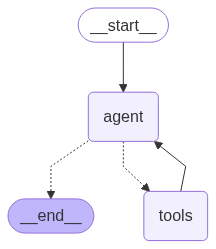

In [ ]:
from IPython.display import Image

display(Image(single_agent.get_graph().draw_mermaid_png()))

In [ ]:
!gdown 1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB

Downloading...
From (original): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB
From (redirected): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB&confirm=t&uuid=c26656c4-ab8d-4b85-8e63-b50cc2f776d6
To: /content/agent_utils.py
100% 6.38k/6.38k [00:00<00:00, 16.3MB/s]


### Stream Agent Exeuction

In [ ]:
from agent_utils import format_message

def call_agent_system(agent, prompt, verbose=False):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 25},
        stream_mode="values"
    )
    for event in events:
        if verbose:
            format_message(event["messages"][-1])

    print('\n\nFinal Response:')
    display(Markdown(event["messages"][-1].content))

In [ ]:
prompt = "Review patient P101 for procedure justification."
call_agent_system(single_agent, prompt, verbose=True)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Review patient P101 for procedure justification.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: fetch_patient_record                                                                              │
│    Args: {                                                                                                      │
│   "patient_id": "P101"                                                                                          │
│ }                                                                                                               │
│    ID: call_myU0Xr5GOrBlN2PHftHc7sE8                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"patient_summary": "Patient ID: P101\nAge: 38, Sex: Male\nReported Symptoms: abdominal pain,                   │
│ nausea\nPreliminary Diagnosis: Possible early appendicitis\nRequested Procedure: CT Abdomen\nClinical Notes:    │
│ Mild abdominal pain and nausea but no localized tenderness or rebound noted."}                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: match_guideline                                                                                   │
│    Args: {                                                                                                      │
│   "procedure": "CT Abdomen",                                                                                    │
│   "diagnosis": "Possible early appendicitis"                                                                    │
│ }                                                                                                               │
│    ID: call_e6LNbT0SE8z0pPk9uoKAXx8m                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"matched_guideline": "The patient's procedure is a CT Abdomen, and the diagnosis is possible early             │
│ appendicitis. \n\nUpon reviewing the available guidelines, the one that best fits this case is:\n\n**Guideline: │
│ CT Abdomen, Diagnosis: Suspected Appendicitis**\n- **Required Symptoms:** ['abdominal pain', 'nausea', 'RLQ     │
│ tenderness']\n- **Notes:** CT imaging justified if appendicitis is unclear.\n\nThis guideline indicates that a  │
│ CT Abdomen is appropriate for evaluating suspected appendicitis, especially when the diagnosis is uncertain and │
│ the patient presents with relevant symptoms such as abdominal pain, nausea, and right lower quadrant            │
│ tenderness. \n\nIn this case, since the diagnosis is possible early appendicitis, the CT Abdomen aligns with    │
│ the guideline, as it is justified to clarify the diagnosis."}                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: check_guideline_validity                                                                          │
│    Args: {                                                                                                      │
│   "symptoms": [                                                                                                 │
│     "abdominal pain",                                                                                           │
│     "nausea"                                                                                                    │
│   ],                                                                                                            │
│   "required_symptoms": [                                                                                        │
│     "abdominal pain",                                                                                           │
│     "nausea",                                                                                                   │
│     "RLQ tenderness"                                                                                            │
│   ],                                                                                                            │
│   "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."                       │
│ }                                                                                                               │
│    ID: call_15kxoUspOb6w6MWy5ylWy2jl                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"validity_result": "Based on the provided information, the patient's symptoms include abdominal pain and       │
│ nausea, which align with two of the three required symptoms from the guideline. However, the guideline          │
│ specifies that RLQ (right lower quadrant) tenderness is also necessary for the procedure request to be          │
│ considered medically necessary.\n\nIn the clinical notes, it is mentioned that there is mild abdominal pain and │
│ nausea, but importantly, there is no localized tenderness or rebound noted. This indicates that the patient     │
│ does not exhibit the required RLQ tenderness, which is a critical component of the guideline                    │
│ criteria.\n\nTherefore, the procedure does not qualify as medically necessary because the patient does not meet │
│ all the required symptoms outlined in the guideline. Specifically, the unmet criterion is the absence of RLQ    │
│ tenderness."}                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: recommend_care_plan                                                                               │
│    Args: {                                                                                                      │
│   "diagnosis": "Possible early appendicitis"                                                                    │
│ }                                                                                                               │
│    ID: call_J9eXcQ96nbyWXWLH0pcOa6s2                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"recommendation": "The closest match from the list of known recommendations for the diagnosis of possible      │
│ early appendicitis is:\n\n**Diagnosis: Suspected Appendicitis, Recommendation: Do CT to confirm and refer for   │
│ surgery if positive.**\n\n**Explanation:**\nThis recommendation is appropriate because it directly addresses    │
│ the concern of appendicitis, which is characterized by inflammation of the appendix. In cases of suspected      │
│ appendicitis, imaging, such as a CT scan, is often utilized to confirm the diagnosis. If the CT scan indicates  │
│ appendicitis, surgical intervention (appendectomy) is typically required to prevent complications such as       │
│ perforation or abscess formation. Therefore, this recommendation aligns perfectly with the need to evaluate and │
│ manage a potential case of early appendicitis."}                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ - Final Decision: NEEDS REVIEW                                                                                  │
│ - Decision Reasoning: The patient's symptoms include abdominal pain and nausea, but they do not exhibit the     │
│ required RLQ tenderness, which is necessary for the procedure to be considered medically necessary according to │
│ the guideline.                                                                                                  │
│ - Care recommendation or alternative steps: Recommend further evaluation and monitoring of symptoms; consider   │
│ alternative imaging or clinical assessment before proceeding with a CT Abdomen. If symptoms worsen or RLQ       │
│ tenderness develops, re-evaluate for possible appendicitis and consider CT scan.                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯



Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The patient's symptoms include abdominal pain and nausea, but they do not exhibit the required RLQ tenderness, which is necessary for the procedure to be considered medically necessary according to the guideline.
- Care recommendation or alternative steps: Recommend further evaluation and monitoring of symptoms; consider alternative imaging or clinical assessment before proceeding with a CT Abdomen. If symptoms worsen or RLQ tenderness develops, re-evaluate for possible appendicitis and consider CT scan.

## Multi-Agent System with Supervisor

The diagram illustrates a **multi-agent architecture** designed for healthcare decision support.  
It consists of several specialized agents, datasets, and tools orchestrated under a supervisor.

![](https://i.imgur.com/EzayV5W.png)

#### 1. Supervisor Agent
- Central coordinator of the workflow.  
- Uses a **System Prompt** and an **LLM** to decide which specialized agent should handle a task.  
- Collects results and routes them to produce the **Final Decision Output**.

#### 2. Specialized Agents
- **Clinical Intake Agent (📄)**  
  - Gathers patient information.  
  - Interacts with the **Patient Records** dataset through the **Fetch Patient Record** tool.  

- **Guideline Checker Agent (📊)**  
  - Validates care recommendations against medical standards.  
  - Uses the **Match Guideline** and **Check Guideline Validity** tools with the **Medical Guidelines** dataset.  

- **Care Recommender Agent (💡)**  
  - Suggests appropriate treatments or interventions.  
  - Accesses the **Care Recommendations** dataset using the **Fetch Recommendation** tool.  

Each agent runs on a **System Prompt** + **LLM** combination for reasoning.

#### 3. Tools Layer
- Interfaces that allow agents to access external knowledge.  
- Includes:
  - 📄 **Fetch Patient Record**
  - 📊 **Match Guideline**
  - ✅ **Check Guideline Validity**
  - 💡 **Fetch Recommendation**

#### 4. Datasets Layer
- **Patient Records**  
- **Medical Guidelines**  
- **Care Recommendations**  

These serve as the structured data sources powering the agents’ reasoning.

#### 5. Final Output
- The **Supervisor Agent** aggregates results from the intake, guideline validation, and recommendation agents.  
- Produces a **Final Decision Output** for clinical use.

### Implement Sub-Agents (Worker Agents)

In [ ]:
clinical_intake_agent = create_react_agent(
    llm,
    tools=[fetch_patient_record],
    prompt=SystemMessage(content="""You are acting as a clinical intake specialist responsible for reviewing and summarizing a patient's medical case.

Your responsibilities:
1. Carefully read the symptoms, diagnosis, procedure, and notes with the right tool.
2. Generate a medically accurate clinical summary (key points).
3. Identify any additional risk factors or inferred clues from notes (e.g., “long flight” → immobility).
4. Derive the clinical rationale for why the procedure may have been ordered.

Your final message must clearly include:
- A clinical summary
- Key clinical findings (explicit or inferred)

Present your output as if it’s being passed to a medical reviewer for decision-making.
""")
)

guideline_checker_agent = create_react_agent(
    llm,
    tools=[match_guideline, check_guideline_validity],
    prompt=SystemMessage(content="""You are a utilization review specialist evaluating whether a requested procedure is medically justified.

Your responsibilities:
1. Identify the most relevant clinical guideline based on the procedure and diagnosis.
2. If a matching guideline is found, extract the required symptoms.
3. Then use an appropriate tool to check the guideline validity for the patient using:
   - the patient’s documented symptoms
   - the required symptoms from the guideline
   - clinical notes (from the intake summary)

Guidance:
- Use clinical reasoning to validate justification.
- If symptoms and context meet the criteria, justify the procedure clearly.
- If not, explain why the guideline requirements are not satisfied.
- If no matching guideline is found, state that clearly.

Your message should be clear, objective, and appropriate for escalation or approval review.
""")
)

care_recommender_agent = create_react_agent(
    llm,
    tools=[recommend_care_plan],
    prompt=SystemMessage(content="""
You are a clinical care assistant responsible for recommending follow-up actions based on a confirmed diagnosis.

Instructions:
1. Consider the outputs from the intake and guideline checker agents.
2. If the guideline checker has determined that the procedure is NOT justified, you must:
   - Suggest alternate steps (e.g., reassess symptoms, collect more data), OR
   - Justify why a care plan involving that procedure may still be warranted due to risk factors.
3. If the guideline checker approved the procedure, proceed with care planning as usual.

Important:
- Always clarify whether your recommendation is based on an approved procedure or despite a failed guideline check.
- Avoid assuming procedures are approved if guideline validation failed.

Use precise clinical reasoning.
""")
)


### Create Supervisor Agent Node Function

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.types import Command

# Define shared state
class State(TypedDict):
    messages: Annotated[list, add_messages]

members = ["clinical_intake_agent", "guideline_checker_agent", "care_recommender_agent"]

SUPERVISOR_PROMPT = f"""You are a supervisor tasked with managing a healthcare utilization review conversation between the following agents:
{members}.

Each agent performs a specific part of the review process:
- clinical_intake_agent summarizes the patient's case and rationale
- guideline_checker_agent evaluates medical necessity against clinical guidelines
- care_recommender_agent suggests appropriate follow-up care

Read the current messages. Decide who should act next.
If the full workflow is complete, respond with FINISH.
"""

FINAL_RESPONSE_PROMPT = """Analyze all the results from the execution so far before making the final decision

Your final response should ONLY include the following bullets in the exact format specified:

- Final Decision: [APPROVED/NEEDS REVIEW]
- Decision Reasoning: [What criteria matched or did not match]
- Care recommendation or alternative steps: [care plan steps to take or alternative steps if it needs review]

Do NOT add any other extra content in the final response
"""

class Router(TypedDict):
    next: Literal["clinical_intake_agent", "guideline_checker_agent", "care_recommender_agent", "FINISH"]

def supervisor_node(state: State) -> Command[Literal["clinical_intake_agent",
                                                     "guideline_checker_agent",
                                                     "care_recommender_agent",
                                                     "__end__"]]:
    # Figure out which sub-agent should act next
    messages = [SystemMessage(content=SUPERVISOR_PROMPT)] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    # If all agents finished - process context and generate final response
    if goto == "FINISH":
        goto = END
        messages = [SystemMessage(content=FINAL_RESPONSE_PROMPT)] + state["messages"]
        response = llm.invoke(messages)

        return Command(goto=goto, update={"messages": [AIMessage(content=response.content,
                                                                name="supervisor")],
                                          "next": goto})

    return Command(goto=goto, update={"next": goto})

### Create Sub-Agents Node Functions

In [ ]:
def clinical_intake_node(state: State) -> Command[Literal["supervisor"]]:
    result = clinical_intake_agent.invoke(state)
    return Command(
        update={"messages": [AIMessage(content=result["messages"][-1].content,
                                          name="clinical_intake_agent")]},
        goto="supervisor"
    )

def guideline_checker_node(state: State) -> Command[Literal["supervisor"]]:
    result = guideline_checker_agent.invoke(state)
    return Command(
        update={"messages": [AIMessage(content=result["messages"][-1].content,
                                          name="guideline_checker_agent")]},
        goto="supervisor"
    )

def care_recommender_node(state: State) -> Command[Literal["supervisor"]]:
    result = care_recommender_agent.invoke(state)
    return Command(
        update={"messages": [AIMessage(content=result["messages"][-1].content,
                                          name="care_recommender_agent")]},
        goto="supervisor"
    )

### Build the Multi-Agent Graph

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_edge(START, "supervisor")
graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("clinical_intake_agent", clinical_intake_node)
graph_builder.add_node("guideline_checker_agent", guideline_checker_node)
graph_builder.add_node("care_recommender_agent", care_recommender_node)

multi_agent = graph_builder.compile()

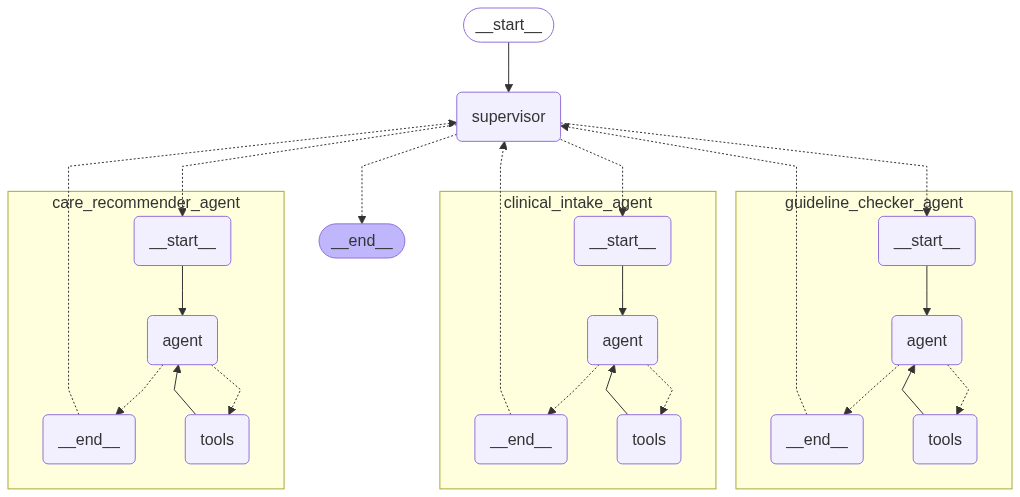

In [ ]:
display(Image(multi_agent.get_graph(xray=True).draw_mermaid_png()))

### Stream Agent Exeuction

In [ ]:
prompt = "Review patient P101 for procedure justification."
call_agent_system(multi_agent, prompt, verbose=True)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Review patient P101 for procedure justification.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ ### Clinical Summary for Patient P101                                                                           │
│                                                                                                                 │
│ - **Patient ID**: P101                                                                                          │
│ - **Age**: 38                                                                                                   │
│ - **Sex**: Male                                                                                                 │
│ - **Reported Symptoms**: The patient presents with abdominal pain and nausea.                                   │
│ - **Preliminary Diagnosis**: Possible early appendicitis.                                                       │
│ - **Requested Procedure**: CT Abdomen.                                                                          │
│ - **Clinical Notes**: The patient exhibits mild abdominal pain and nausea; however, there is no localized       │
│ tenderness or rebound tenderness noted.                                                                         │
│                                                                                                                 │
│ ### Key Clinical Findings                                                                                       │
│                                                                                                                 │
│ - **Symptoms**: Abdominal pain and nausea are common indicators of gastrointestinal issues, including           │
│ appendicitis.                                                                                                   │
│ - **Diagnosis**: The preliminary diagnosis of possible early appendicitis suggests a need for further           │
│ evaluation to confirm or rule out this condition.                                                               │
│ - **Procedure Justification**: A CT scan of the abdomen is indicated to provide detailed imaging of the         │
│ abdominal organs, which can help confirm the diagnosis of appendicitis or identify other potential causes of    │
│ the symptoms. The absence of localized tenderness may warrant imaging to ensure that no serious condition is    │
│ overlooked.                                                                                                     │
│                                                                                                                 │
│ ### Additional Risk Factors or Inferred Clues                                                                   │
│                                                                                                                 │
│ - The patient's age and gender (38-year-old male) are consistent with the demographic most commonly affected by │
│ appendicitis.                                                                                                   │
│ - The mild nature of the symptoms may suggest an early stage of appendicitis, where imaging is crucial for      │
│ diagnosis before the condition potentially worsens.                                                             │
│                                                                                                                 │
│ This summary should assist in the decision-making process regarding the necessity and urgency of the requested  │
│ CT abdomen procedure.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ ### Review of Procedure Justification for Patient P101                                                          │
│                                                                                                                 │
│ **Procedure Requested**: CT Abdomen                                                                             │
│ **Diagnosis**: Possible early appendicitis                                                                      │
│ **Matched Guideline**: CT Abdomen for Suspected Appendicitis                                                    │
│ **Required Symptoms**:                                                                                          │
│ - Abdominal pain                                                                                                │
│ - Nausea                                                                                                        │
│ - RLQ tenderness                                                                                                │
│                                                                                                                 │
│ ### Patient's Documented Symptoms                                                                               │
│ - Abdominal pain                                                                                                │
│ - Nausea                                                                                                        │
│                                                                                                                 │
│ ### Clinical Notes                                                                                              │
│ The patient exhibits mild abdominal pain and nausea; however, there is no localized tenderness or rebound       │
│ tenderness noted.                                                                                               │
│                                                                                                                 │
│ ### Evaluation of Justification                                                                                 │
│ The patient's symptoms of abdominal pain and nausea align with two of the three required symptoms from the      │
│ guideline. However, the guideline specifies that right lower quadrant (RLQ) tenderness is also necessary for    │
│ the procedure request to be considered medically necessary.                                                     │
│                                                                                                                 │
│ **Key Finding**: The clinical notes indicate that the patient does not exhibit RLQ tenderness, which is a       │
│ critical component of the guideline criteria.                                                                   │
│                                                                                                                 │
│ ### Conclusion                                                                                                  │
│ The procedure request for a CT Abdomen does not qualify as medically necessary because the patient does not     │
│ meet the requirement for RLQ tenderness, which is essential according to the guidelines. Therefore, the unmet   │
│ criterion is the absence of RLQ tenderness.                                                                     │
│                                                                                                                 │
│ **Recommendation**: Consider alternative diagnostic approaches or further clinical evaluation before proceeding │
│ with the CT Abdomen.                                                                                            │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The guideline checker has determined that the procedure (CT Abdomen) is NOT justified due to the absence of     │
│ right lower quadrant (RLQ) tenderness, which is a critical requirement for the procedure in cases of suspected  │
│ appendicitis.                                                                                                   │
│                                                                                                                 │
│ ### Recommendations Based on Findings:                                                                          │
│                                                                                                                 │
│ 1. **For Possible Early Appendicitis**:                                                                         │
│    - **Recommendation**: While the CT scan is typically indicated to confirm appendicitis, the absence of RLQ   │
│ tenderness suggests that immediate imaging may not be warranted. Instead, consider:                             │
│      - **Reassessing Symptoms**: Monitor the patient closely for any changes in symptoms, particularly the      │
│ development of RLQ tenderness or worsening pain.                                                                │
│      - **Collecting More Data**: Conduct a thorough physical examination and consider laboratory tests (e.g.,   │
│ CBC, urinalysis) to gather more information before deciding on imaging.                                         │
│                                                                                                                 │
│ 2. **For Abdominal Pain and Nausea Without RLQ Tenderness**:                                                    │
│    - **Recommendation**: No specific care recommendation was found for this diagnosis. However, it is essential │
│ to:                                                                                                             │
│      - **Monitor Symptoms**: Keep track of the patient's symptoms and any new developments.                     │
│      - **Consider Alternative Diagnoses**: Evaluate for other potential causes of abdominal pain and nausea,    │
│ such as gastrointestinal infections or other non-appendiceal conditions.                                        │
│                                                                                                                 │
│ ### Summary                                                                                                     │
│ While the initial suspicion of appendicitis exists, the lack of RLQ tenderness necessitates a more cautious     │
│ approach. Close monitoring and further evaluation are recommended before proceeding with any imaging or         │
│ invasive procedures.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ - Final Decision: NEEDS REVIEW                                                                                  │
│ - Decision Reasoning: The procedure request for a CT Abdomen does not meet the guideline criteria due to the    │
│ absence of right lower quadrant (RLQ) tenderness, which is essential for suspected appendicitis.                │
│ - Care recommendation or alternative steps: Monitor the patient closely for changes in symptoms, conduct a      │
│ thorough physical examination, and consider laboratory tests before deciding on imaging.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯



Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The procedure request for a CT Abdomen does not meet the guideline criteria due to the absence of right lower quadrant (RLQ) tenderness, which is essential for suspected appendicitis.
- Care recommendation or alternative steps: Monitor the patient closely for changes in symptoms, conduct a thorough physical examination, and consider laboratory tests before deciding on imaging.

## Test Execution Times of Single vs. Multi-Agent

In [ ]:
def run_review():
    prompt = "Review patient P102 for procedure justification."
    call_agent_system(single_agent, prompt, verbose=False)

%timeit -n 1 -r 3 run_review()



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The requested CT Chest procedure aligns with clinical guidelines for suspected pulmonary embolism, as the patient presents with required symptoms (chest pain, shortness of breath, tachycardia) and has a high probability Wells score with a positive D-dimer.
- Care recommendation or alternative steps: Begin anticoagulation and confirm with CTPA.



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms (chest pain, shortness of breath, tachycardia) match the required symptoms for the CT Chest procedure as per the guideline for suspected pulmonary embolism (PE). The clinical context (high probability Wells score and positive D-dimer) further supports the medical necessity of the procedure.
- Care recommendation or alternative steps: Begin anticoagulation and confirm with CTPA.



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms (chest pain, shortness of breath, tachycardia) match the required symptoms for the CT Chest procedure as per the guideline for suspected pulmonary embolism (PE). The clinical context (high Wells score and positive D-dimer) supports the medical necessity of the procedure.
- Care recommendation or alternative steps: Begin anticoagulation and confirm with CTPA.

14.9 s ± 597 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
def run_review():
    prompt = "Review patient P102 for procedure justification."
    call_agent_system(multi_agent, prompt, verbose=False)

%timeit -n 1 -r 3 run_review()



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms, high Wells score, and positive D-dimer test align with clinical guidelines indicating the need for a CT Chest to evaluate for pulmonary embolism.
- Care recommendation or alternative steps: Proceed with the CT Chest and initiate anticoagulation therapy to manage the suspected pulmonary embolism.



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The procedure is justified based on the patient's symptoms, high Wells score, and positive D-dimer test, aligning with clinical guidelines for suspected pulmonary embolism.
- Care recommendation or alternative steps: Proceed with the CT Chest and initiate anticoagulation therapy to manage the suspected pulmonary embolism.



Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms, high Wells score, and positive D-dimer test align with guidelines indicating the need for a CT Chest to investigate suspected pulmonary embolism.
- Care recommendation or alternative steps: Proceed with CT pulmonary angiography (CTPA) and initiate anticoagulation therapy to manage the suspected pulmonary embolism.

32.8 s ± 3.32 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
